## Analysis of the connectivity of the neurons investigated in this study
This notebook analyzes the connectivity of the neurons tested in this study among each other. Additionally, the connectivity of the vMS12 neurons is analyzed in more detail to search for potential differences in the connectivity of single neurons which might reveal the vMS12 subtypes. The vPR13 connectivity is analyzed in more detail as these neurons show only little direct connections to the song circuit neurons. 

The dataset is imported as two hdf5 datasets. They can be created using the functions `cfun.fetch_all_connections()` and `cfun.fetch_all_neuron_props()`.

Terms: 
 - 'weight' - number of synaptic connections between two neurons
 - 'post' - number of postsynaptic sites on a neuron in the MANC dataset (inputs)
 - 'pre' -  number of presynaptic sites on a neuron in the MANC dataset (outputs)
 - A simple path is a path with no repeated nodes in the networkx module. 

AN08B031 corresponds to vPR13 according to Lillvis et al. (2024, https://doi.org/10.1016/j.cub.2024.01.015).

Author: Bjarne Schultze <br>
Last modified: 14.11.2024

In [1]:
import neuprint as neup                     # module with convenience functions for connectome handling
import networkx as nx                       # module for network analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import modules.connectome_fun as cfun               # my own module with convenience functions for connectome handling
import modules.plotting_utils as myplt              # my own module with plotting and plot modification functions

plt.style.use('plotstyle_bjarne.mplstyle')  # custom matplotlib plot style

##### Preparations

In [2]:
# Load the connections and neuron information
connections = pd.read_hdf('../additional_files/manc_1.2.1_connections.h5')
neuron_info = pd.read_hdf('../additional_files/manc_1.2.1_neurons.h5')

# Re-name AN08B031 to vPR13 (IDs checked to ensure same neurons in old and new MANC version)
connections.replace("AN08B031", "vPR13", inplace=True)
neuron_info.replace("AN08B031", "vPR13", inplace=True)

# Create ID and type dicts
neuron_type_dict = cfun.create_neuron_dict(pd.DataFrame(neuron_info), key_type='type')
neuron_id_dict = cfun.create_neuron_dict(pd.DataFrame(neuron_info), key_type='id')

# Set a color for things analyzed in this study, associate with neuron names in dict form
col_this_study = "#481594"
col_dict_this_study = { key:col_this_study for key in ["TN1a", "vPR13", "vMS12", "pIP10"] }

##### Analysis

In [3]:
# Define a list of neurons to consider
neuron_list_c = np.array(['pIP10', 'TN1a', 'vPR13', 'vMS12', 'pMP2', 'dPR1', 'dMS9', 'dMS2', 'vPR9']) 
mn_neuorns = np.array(['i2 MN','DLMn a, b','DLMn c-f', 'hg1 MN', 'tp1 MN', 'tp2 MN', 'tpn MN','DVMn 1a-c','DVMn 2a, b','DVMn 3a, b'])
neuron_list = np.concatenate([neuron_list_c, mn_neuorns])

# Sum the connections between the same bodyIDs
neuron_inter_connections = connections.groupby(['bodyId_pre', 'bodyId_post'], as_index=False)['weight'].sum()

# Merge neuron properties onto the connection data frame
inter_conns = neup.merge_neuron_properties(neuron_info, neuron_inter_connections, 
                                           ['type','instance','predictedNt', 'predictedNtProb']).drop(['predictedNtProb_post','predictedNt_post'], axis=1)

# Sum all connection weights per cell type, constrain the dataset to a minimal weight of 10 
min_weight = 10
conn_df_ntype = inter_conns.loc[inter_conns['weight'] >= min_weight, :].groupby(['type_pre', 'type_post'], as_index=False)['weight'].sum()

# Convert the connection data frame to a connectivity matrix
conn_mat, total_input_weights = cfun.generate_conn_mat(inter_conns, "type_pre", "type_post", subset=[neuron_list, neuron_list], return_norm_arr=True)

In [4]:
# Re-shape connectivity matrix
# Drop the motor neurons on the pre-synaptic side
conn_mat_re = conn_mat.drop(mn_neuorns.tolist(), axis=0)

# Compute new normalized input connections for the grouped neuron types
conn_mat_temp = conn_mat_re.loc[:, mn_neuorns] * total_input_weights.loc[mn_neuorns]
dlmns = conn_mat_temp.loc[:, ['DLMn a, b','DLMn c-f']].sum(axis=1) / total_input_weights.loc[['DLMn a, b','DLMn c-f']].sum()
tpmns = conn_mat_temp.loc[:, ['tp1 MN','tp2 MN', 'tpn MN']].sum(axis=1) / total_input_weights.loc[['tp1 MN','tp2 MN', 'tpn MN']].sum()
dvmns = conn_mat_temp.loc[:, ['DVMn 1a-c','DVMn 2a, b', 'DVMn 3a, b']].sum(axis=1) / total_input_weights.loc[['DVMn 1a-c','DVMn 2a, b', 'DVMn 3a, b']].sum()

# Insert the newly calculated values and remove the un-grouped neuron types
conn_mat_re = conn_mat_re.drop(['DVMn 1a-c','DVMn 2a, b', 'DVMn 3a, b', 'DLMn a, b','DLMn c-f', 'tp1 MN','tp2 MN', 'tpn MN'], axis=1)
conn_mat_re.loc[:, "DLMns"] = dlmns
conn_mat_re.loc[:, "DVMns"] = dvmns
conn_mat_re.loc[:, "tp MNs"] = tpmns

# Convert to percent
conn_mat_re = conn_mat_re * 100

##### Plotting of the results

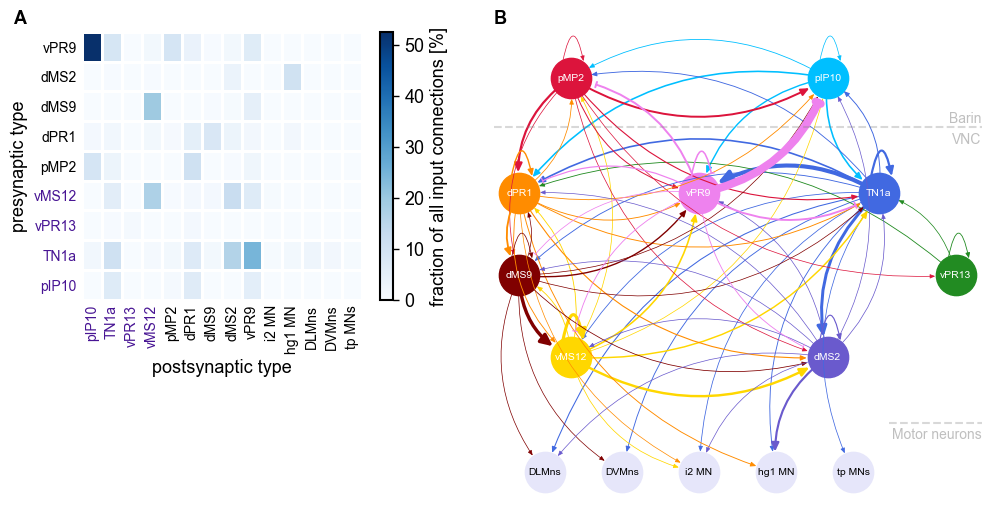

In [5]:
# Set a colormap
cmap = plt.cm.Blues
# Create axes labels and define tick values
y_labels = conn_mat_re.index.to_list()
y_ticks = np.arange(0.5,len(y_labels)+0.5,1)
x_labels = conn_mat_re.columns.to_list()
x_ticks = np.arange(0.5,len(x_labels)+0.5,1)

# Allocate a list to store the arrow objects
arrows = []

# Assign positions for all the neurons, store as dict
#             ['pIP10',   'TN1a',  'vPR13', 'vMS12', 'pMP2',   'dPR1',  'dMS9',  'dMS2',  'vPR9',  'i2 MN', 'hg1 MN',  'DLMns',  'DVMns', 'tp MNs']
neurons_pos = [(75,170), (85,100), (100,50), (25,0), (25,170), (15,100), (15,50), (75,0), (50,100), (50,-70), (65,-70), (20,-70), (35,-70), (80,-70)]
npos_dict = {key:val for key,val in zip(x_labels, neurons_pos)}
# Create a dict mapping colors to neurons
col_dict = {key:val for key,val in zip(x_labels, ["deepskyblue", "royalblue", "forestgreen", "gold", "crimson", "darkorange", "maroon", "slateblue", 
                                                 "violet", "lavender", "lavender", "lavender", "lavender", "lavender"])}


# Create figure
# fig, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=False)
fig, ax_dict = plt.subplot_mosaic([["A", "A", "A", "B", "B", "B", "B"],
                                   ["A", "A", "A", "B", "B", "B", "B"],
                                   ["A", "A", "A", "B", "B", "B", "B"],
                                   ["C", "C", "C", "B", "B", "B", "B"],
                                   ["C", "C", "C", "B", "B", "B", "B"]], figsize=(10, 5), constrained_layout=False)
axa = ax_dict["A"]
axb = ax_dict["B"]

# Plot connectivity matrix 
pcm = axa.pcolormesh(conn_mat_re, cmap=cmap, edgecolors="w", linewidth=1)
fig.colorbar(pcm, ax=axa, label="fraction of all input connections [%]")
# Label axes
axa.set_yticks(y_ticks, y_labels, fontsize=10)
axa.set_xticks(x_ticks, x_labels,  rotation=90, fontsize=10)
axa.set_ylabel('presynaptic type')
axa.set_xlabel('postsynaptic type')

# Color the axes labels (x)
myplt.ax_colorcode(axa, col_dict_this_study)

# Remove spines and ticks
axa.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
axa.tick_params(axis="both", length=0)


## Second subplot
# Plot the neuorns as dots
for i in x_labels:
    axb.plot(*npos_dict[i], marker="o", markersize=29, linestyle="", alpha=1, zorder=-1, color=col_dict[i])
    if i in ['i2 MN', 'hg1 MN',  'DLMns',  'DVMns', 'tp MNs']:
        axb.text(*npos_dict[i], i, fontsize=7.5, horizontalalignment="center", verticalalignment="center", color="k")
    else:
        axb.text(*npos_dict[i], i, fontsize=7.5, horizontalalignment="center", verticalalignment="center", color="w")

# Create arrows connecting the neuron dots with different line widths according to the connection strength
# Discard any connections below 0.05 %
for j in conn_mat_re.index.to_list():
    for i in x_labels:
        if conn_mat_re.loc[j, i] > 0.05:
            weight = conn_mat_re.loc[j, i] / 10 + 0.5
            if j == "vPR9":
                # Distinguish between self-connections and connections to other neuron types
                if i == "vPR9":
                    pos_1 = (npos_dict[j][0]-2, npos_dict[j][1]+2)
                    pos_2 = (npos_dict[i][0]+3, npos_dict[i][1]+2)
                    arrows.append(patches.FancyArrowPatch(pos_1, pos_2, connectionstyle="arc3,rad=-3", 
                                                arrowstyle=patches.ArrowStyle("|-|", widthA=0, widthB=2.0), 
                                                linewidth=weight, shrinkA=10, shrinkB=12, color=col_dict[j]))
                else:
                    arrows.append(patches.FancyArrowPatch(npos_dict[j], npos_dict[i], connectionstyle="arc3,rad=.3", 
                                                arrowstyle=patches.ArrowStyle("|-|", widthA=0, widthB=2.0), 
                                                linewidth=weight, shrinkA=14, shrinkB=19, color=col_dict[j]))
            else:
                # Distinguish between self-connections and connections to other neuron types
                if i == j:
                    pos_1 = (npos_dict[j][0]-2, npos_dict[j][1]+2)
                    pos_2 = (npos_dict[i][0]+3, npos_dict[i][1]+2)
                    arrows.append(patches.FancyArrowPatch(pos_1, pos_2, connectionstyle="arc3,rad=-3", 
                                                    arrowstyle=patches.ArrowStyle("-|>", head_length=weight*2+2, head_width=weight+0.75), 
                                                    linewidth=weight, shrinkA=10, shrinkB=10, color=col_dict[j]))
                else:
                    arrows.append(patches.FancyArrowPatch(npos_dict[j], npos_dict[i], connectionstyle="arc3,rad=.3", 
                                                    arrowstyle=patches.ArrowStyle("-|>", head_length=weight*2+2, head_width=weight+0.75), 
                                                    linewidth=weight, shrinkA=14, shrinkB=15, color=col_dict[j]))
            

[ axb.add_patch(arr) for arr in arrows ] 

axb.set_ylim(-85, 198) 
axb.set_xlim(10, 105) 
ax_dict["C"].axis("off")
axb.axis("off")

# Add lines and text to mark the different areas/classes of neurons
axb.hlines(140, 10, 105, 'gray', alpha=0.3, linestyles="dashed")
axb.hlines(-40, 87, 105, 'gray', alpha=0.3, linestyles="dashed")
axb.text(105, 141, "Barin", color='gray', alpha=0.5, verticalalignment="bottom", horizontalalignment="right")
axb.text(105, 137, "VNC", color='gray', alpha=0.5, verticalalignment="top", horizontalalignment="right")
axb.text(105, -43, "Motor neurons", color='gray', alpha=0.5, verticalalignment="top", horizontalalignment="right")


# Add titles
axa.set_title("A", x=-0.24)
axb.set_title("B")

# Adjust the subplot layout
plt.subplots_adjust(wspace=0.8, hspace=0.4, left=0.08, right=0.98, top=0.94, bottom=0.01)

# Save figure
# fig.savefig("../figures_wip/connectivity_candidates.pdf")

In [6]:
conn_mat_re

type_post,pIP10,TN1a,vPR13,vMS12,pMP2,dPR1,dMS9,dMS2,vPR9,i2 MN,hg1 MN,DLMns,DVMns,tp MNs
type_pre,,,,,,,,,,,,,,
pIP10,0.175439,6.600016,0.014574,0.004588,0.938338,6.547032,0.010078,0.033538,5.218638,0.000000,0.000000,0.000000,0.000000,0.000000
TN1a,1.812865,10.812156,0.019433,0.864778,1.340483,6.862552,1.400786,16.389536,24.626045,0.608121,1.272578,2.568686,1.466910,0.418546
vPR13,0.000000,0.356488,1.010494,0.000000,0.000000,1.119109,0.000000,0.001765,0.014337,0.000000,0.000000,0.000000,0.000000,0.000000
vMS12,0.175439,5.542500,0.000000,17.018007,0.268097,1.188129,1.027915,12.479701,6.671446,0.420156,0.014661,0.002277,0.047773,0.022548
pMP2,9.181287,3.041106,0.097163,0.036701,0.134048,10.826267,0.131009,0.211820,2.093190,0.000000,0.000000,0.000000,0.000000,0.000000
dPR1,1.052632,1.710746,0.019433,1.266200,0.670241,4.999014,8.162854,2.940761,1.476703,0.077397,1.612714,0.030742,0.005620,0.019729
dMS9,0.116959,0.083645,0.000000,19.534350,0.000000,0.088740,0.322483,0.587799,4.903226,0.000000,0.014661,0.095643,0.061824,0.004228
dMS2,0.058480,0.268860,0.000000,0.206446,0.000000,0.064090,0.060466,3.120808,0.124253,0.052520,10.377082,0.088811,0.002810,0.040868
vPR9,52.456140,8.661276,0.048581,1.312077,9.182306,3.653126,0.382949,1.246205,6.255675,0.044227,0.011729,0.000000,0.002810,0.004228


### Analysis of the connectivity of the vMS12 neurons

According to Lillvis et al. (2024) there are 14 bilaterally and 6 ipsilaterally stratifying vMS12 neurons in their lines. While the SS1 and SS2 line
label ipsi- and bilaterally stratifying neurons, the SS3 line only labels bilateral neuorns. The ipsilateral neurons and only to be found in the 
MANC systematic type IN12A023 (MANC v1.2.1). 

I tried to identify the neurons that mainly stratify ipsilaterally among the IN12A023 neurons. The distinction is not straightforward in some cases, so the
classification should be used with care. 

##### Analysis

In [7]:
# Get the vMS12 body IDs
vMS12_ids = neuron_type_dict['vMS12']
# Calculate the total input weights for all vMS12 neuorns
total_in_weights_vm12ids = [ inter_conns.loc[inter_conns["bodyId_post"] == id, "weight"].sum() for id in vMS12_ids ]

# Fetch the connections from vMS12 neurons to the other neurons
conn_from_vms12 = inter_conns.groupby(["bodyId_pre","type_post"], 
                                      as_index=False)["weight"].sum().pivot(columns="type_post", index="bodyId_pre", 
                                                                            values="weight").loc[vMS12_ids, neuron_list_c].fillna(0.0) / total_input_weights[neuron_list_c]
# Fetch connections from vMS12 to motor neurons
conn_vms12_mns = inter_conns.groupby(["bodyId_pre","type_post"], 
                                      as_index=False)["weight"].sum().pivot(columns="type_post", index="bodyId_pre", 
                                                                            values="weight").loc[vMS12_ids, np.append(mn_neuorns, "ps1 MN")].fillna(0.0) / total_input_weights[neuron_list_c]

# Fetch the connections from the other neurons to the vMS12 neurons
conn_to_vms12 = inter_conns.groupby(["type_pre","bodyId_post"], 
                                    as_index=False)["weight"].sum().pivot(columns="bodyId_post",
                                                                          index="type_pre", values="weight").loc[neuron_list_c, vMS12_ids].fillna(0.0) / total_in_weights_vm12ids

# Create a custom sorting index for the vMS12 body IDs
sort_idx_vms12 = [3, 6, 7, 12, 17, 19, 5, 8, 9, 10, 0, 1, 2, 4, 11, 13, 14, 15, 16, 18]
# Apply the sort index
conn_from_vms12 = conn_from_vms12.iloc[sort_idx_vms12, :]
conn_to_vms12 = conn_to_vms12.iloc[:, sort_idx_vms12]

# Convert to percent
conn_from_vms12 = conn_from_vms12 * 100
conn_to_vms12 = conn_to_vms12 * 100

In [8]:
# Store the body IDs for which I would say they stratify mainly ipsilaterally 
vMS12_systype_in12a023_ips = [13518, 14183, 14534, 16920, 23069, 101397]     # 101397 is one where I am least confident
# Store the body IDs for the vMS12 systematic types (MANC v1.2.1)
vMS12_systype_in12a014 = [12887, 12905, 13240, 13855]
vMS12_systype_in12a023_bi = [14126, 15364, 15875, 16317]
vMS12_systype_in12a040 = [16889, 17931, 18452, 19042, 21441, 32714]

# Fetch the connections between the vMS12 neurons
conn_inter_vms12 = inter_conns.loc[np.logical_and(inter_conns["type_pre"] == "vMS12", 
                                                  inter_conns["type_post"] == "vMS12"), :].pivot(columns="bodyId_post", 
                                                                                                 index="bodyId_pre", 
                                                                                                 values="weight").loc[vMS12_ids, vMS12_ids].fillna(0.0) / total_in_weights_vm12ids

# Apply the sort index
conn_inter_vms12 = conn_inter_vms12.iloc[sort_idx_vms12, sort_idx_vms12]

# Convert to percent
conn_inter_vms12 = conn_inter_vms12 * 100

##### Plotting of the results

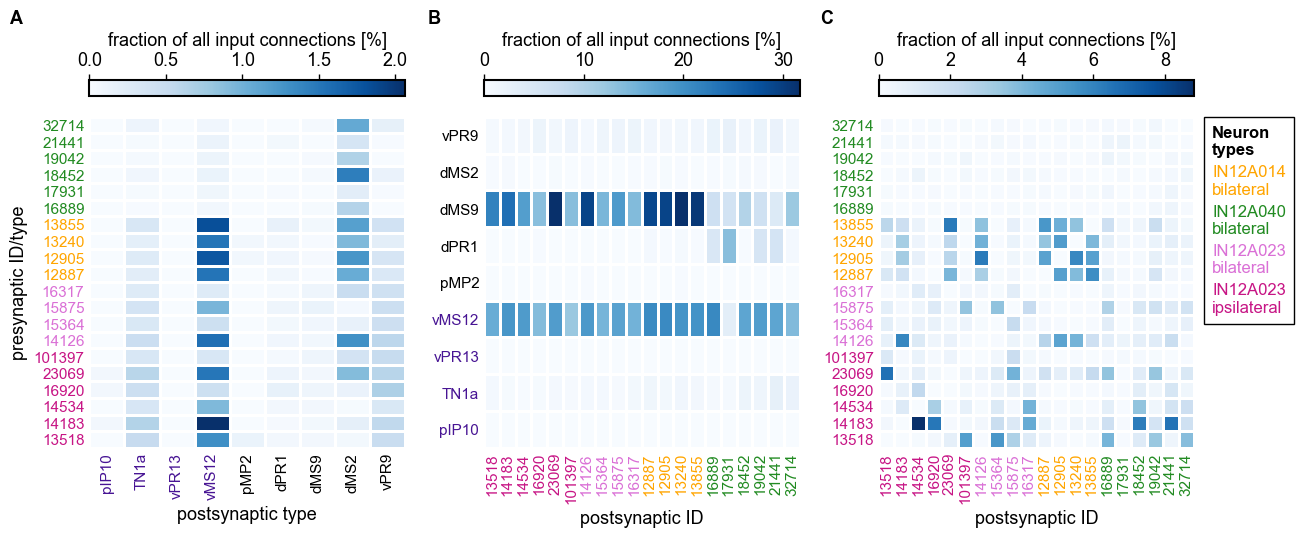

In [9]:
# Define axes ticks and tick labels
y_labels_f = conn_from_vms12.index.to_list()
y_ticks_f = np.arange(0.5,len(y_labels_f)+0.5,1)
x_labels_f = conn_from_vms12.columns.to_list()
x_ticks_f = np.arange(0.5,len(x_labels_f)+0.5,1)

y_labels_t = conn_to_vms12.index.to_list()
y_ticks_t = np.arange(0.5, len(y_labels_t)+0.5, 1)

# Set a colormap
cmap3 = plt.cm.Blues

fig3, ax3 = plt.subplots(1, 3, figsize=(13,5.3), constrained_layout=False)
# Plot the binary connectivity matrix
pcm3_f = ax3[0].pcolormesh(conn_from_vms12, cmap=cmap3, edgecolors='w', linewidth=1)
pcm3_t = ax3[1].pcolormesh(conn_to_vms12, cmap=cmap3, edgecolors='w', linewidth=1)
pcm4 = ax3[2].pcolormesh(conn_inter_vms12, cmap=cmap3, edgecolors='w', linewidth=1)

cbar_t = fig3.colorbar(pcm3_t, ax=ax3[1], label="fraction of all input connections [%]", location="top")
cbar_f = fig3.colorbar(pcm3_f, ax=ax3[0], label="fraction of all input connections [%]", location="top")
cbar_ft = fig3.colorbar(pcm4, ax=ax3[2], label="fraction of all input connections [%]", location="top")

# Label the axes
ax3[0].set_yticks(y_ticks_f, y_labels_f, fontsize=11)
ax3[0].set_xticks(x_ticks_f, x_labels_f,  rotation=90, fontsize=11)
ax3[0].set_ylabel('presynaptic ID/type')
ax3[0].set_xlabel('postsynaptic type')
cbar_f.ax.set_title("A", x=-0.25)

ax3[1].set_xticks(y_ticks_f, y_labels_f, rotation=90, fontsize=11)
ax3[1].set_yticks(y_ticks_t, y_labels_t, fontsize=11)
ax3[1].set_xlabel('postsynaptic ID')
cbar_t.ax.set_title("B", x=-0.18)

ax3[2].set_yticks(y_ticks_f, y_labels_f, fontsize=11)
ax3[2].set_xticks(y_ticks_f, y_labels_f,  rotation=90, fontsize=11)
ax3[2].set_xlabel('postsynaptic ID')
cbar_ft.ax.set_title("C", x=-0.185)

# Create a dictionary mapping colors to systematic types
color_names = {'IN12A014\nbilateral':'orange', 'IN12A040\nbilateral':'forestgreen', 'IN12A023\nbilateral':'orchid', 'IN12A023\nipsilateral':'mediumvioletred'}
# Create a dictionary mapping colors to body IDs
color_dict = { str(key):'orange' for key in vMS12_systype_in12a014 }
for key in vMS12_systype_in12a040: color_dict[str(key)] = 'forestgreen'
for key in vMS12_systype_in12a023_bi: color_dict[str(key)] = 'orchid'
for key in vMS12_systype_in12a023_ips: color_dict[str(key)] = 'mediumvioletred' 

# Color-code the axes labels according to the systematic types
myplt.ax_colorcode(ax3[0], color_dict, axis="y")
myplt.ax_colorcode(ax3[0], col_dict_this_study, axis="x")
myplt.ax_colorcode(ax3[1], color_dict, axis="x")
myplt.ax_colorcode(ax3[1], col_dict_this_study, axis="y")
myplt.ax_colorcode(ax3[2], color_dict, axis="both", legend=True, color_names=color_names, l_title="Neuron\ntypes")

# Remove the spines and ticks
ax3[0].spines[['right', 'top', 'left', 'bottom']].set_visible(False)
ax3[0].tick_params(length=0)
ax3[1].spines[['right', 'top', 'left', 'bottom']].set_visible(False)
ax3[1].tick_params(length=0)
ax3[2].spines[['right', 'top', 'left', 'bottom']].set_visible(False)
ax3[2].tick_params(length=0)

# Adjust the subplot layout
plt.subplots_adjust(wspace=0.25, hspace=0.5, left=0.07, right=0.92, top=0.94, bottom=0.16)

# fig3.savefig("../figures_wip/vms12_connectivity.pdf")

#### Analyze the vMS12 to motor neuron connectivity

In [25]:
# Get the vMS12 body IDs
vMS12_ids = neuron_type_dict['vMS12']

# Append ps1 to the motor neurons
mns_ps1 = np.append(mn_neuorns, "ps1 MN")

# Fetch connections from vMS12 to motor neurons
conn_vms12_mns = inter_conns.groupby(["bodyId_pre","type_post"], 
                                      as_index=False)["weight"].sum().pivot(columns="type_post", index="bodyId_pre", 
                                                                            values="weight").loc[vMS12_ids, mns_ps1].fillna(0.0) / total_input_weights[mns_ps1]


# Create a custom sorting index for the vMS12 body IDs
sort_idx_vms12 = [3, 6, 7, 12, 17, 19, 5, 8, 9, 10, 0, 1, 2, 4, 11, 13, 14, 15, 16, 18]
# Apply the sort index
conn_vms12_mns = conn_vms12_mns.iloc[sort_idx_vms12, :]


# Compute new normalized input connections for the grouped neuron types
conn_mat_temp = conn_vms12_mns.loc[:, mns_ps1] * total_input_weights.loc[mns_ps1]
dlmns = conn_mat_temp.loc[:, ['DLMn a, b','DLMn c-f']].sum(axis=1) / total_input_weights.loc[['DLMn a, b','DLMn c-f']].sum()
tpmns = conn_mat_temp.loc[:, ['tp1 MN','tp2 MN', 'tpn MN']].sum(axis=1) / total_input_weights.loc[['tp1 MN','tp2 MN', 'tpn MN']].sum()
dvmns = conn_mat_temp.loc[:, ['DVMn 1a-c','DVMn 2a, b', 'DVMn 3a, b']].sum(axis=1) / total_input_weights.loc[['DVMn 1a-c','DVMn 2a, b', 'DVMn 3a, b']].sum()

# Insert the newly calculated values and remove the un-grouped neuron types
conn_vms12_mns = conn_vms12_mns.drop(['DVMn 1a-c','DVMn 2a, b', 'DVMn 3a, b', 'DLMn a, b','DLMn c-f', 'tp1 MN','tp2 MN', 'tpn MN'], axis=1)
conn_vms12_mns.loc[:, "DLMns"] = dlmns
conn_vms12_mns.loc[:, "DVMns"] = dvmns
conn_vms12_mns.loc[:, "tp MNs"] = tpmns

# Convert to percent
conn_vms12_mns = conn_vms12_mns * 100

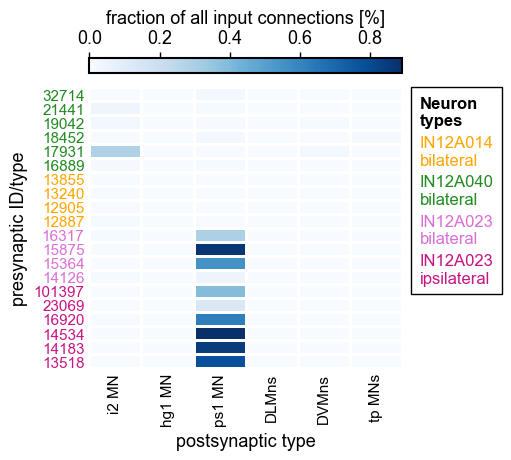

In [ ]:
# Define axes ticks and tick labels
y_labels_f = conn_vms12_mns.index.to_list()
y_ticks_f = np.arange(0.5,len(y_labels_f)+0.5,1)
x_labels_f = conn_vms12_mns.columns.to_list()
x_ticks_f = np.arange(0.5,len(x_labels_f)+0.5,1)

# Set a colormap
cmap3 = plt.cm.Blues

fig4, ax4 = plt.subplots(1, 1, figsize=(5, 4.5))
# Plot the binary connectivity matrix
pcm4_f = ax4.pcolormesh(conn_vms12_mns, cmap=cmap3, edgecolors='w', linewidth=1)
cbar_t = fig4.colorbar(pcm4_f, ax=ax4, label="fraction of all input connections [%]", location="top")

# Label the axes
ax4.set_yticks(y_ticks_f, y_labels_f, fontsize=11)
ax4.set_xticks(x_ticks_f, x_labels_f,  rotation=90, fontsize=11)
ax4.set_ylabel('presynaptic ID/type')
ax4.set_xlabel('postsynaptic type')


# Create a dictionary mapping colors to systematic types
color_names = {'IN12A014\nbilateral':'orange', 'IN12A040\nbilateral':'forestgreen', 'IN12A023\nbilateral':'orchid', 
               'IN12A023\nipsilateral':'mediumvioletred'}
# Create a dictionary mapping colors to body IDs
color_dict = { str(key):'orange' for key in vMS12_systype_in12a014 }
for key in vMS12_systype_in12a040: color_dict[str(key)] = 'forestgreen'
for key in vMS12_systype_in12a023_bi: color_dict[str(key)] = 'orchid'
for key in vMS12_systype_in12a023_ips: color_dict[str(key)] = 'mediumvioletred' 

# Color-code the axes labels according to the systematic types
myplt.ax_colorcode(ax4, color_dict, axis="both", legend=True, color_names=color_names, l_title="Neuron\ntypes")

# Remove the spines and ticks
ax4.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
ax4.tick_params(length=0)

# Adjust the subplot layout
# plt.subplots_adjust(left=0.2, right=0.75, top=0.98, bottom=0.2)

fig4.savefig("../figures_wip/vms12_mn_connectivity.pdf")

### Analysis of the connectivity of the vPR13 neurons

Since the vPR13 neurons show little direct connectivity to the song circuit, I analyzed possible paths with one to two intermediate neurons (path length 2-3). For this I utilized the networkx module and built a directed graph from the MANC connections table. 

##### Analysis

In [5]:
# Create a directional network graph with neuron types as nodes
ngraph_ntype = nx.from_pandas_edgelist(conn_df_ntype, source='type_pre', target='type_post', edge_attr='weight', create_using=nx.DiGraph)

# Create a dictionary mapping neuron types and neurotransmitters 
type_nt_dict = {}
for key in pd.unique(connections['type_pre']):
    # Map neurotransmitter if the predicted transmitter has a probability over 70 % (average over all neurons of that type)
    ntProb = neuron_info.loc[neuron_info['type'] == key, 'predictedNtProb'].to_numpy()
    if ntProb.size > 0 and np.mean(ntProb) > 0.70:
        # Get neurotransmitters
        nt = np.unique(neuron_info.loc[neuron_info['type'] == key,'predictedNt'].to_list())
        if nt.size == 1 and 'gaba' in nt:
            type_nt_dict[key] = "inhibitory"
        elif nt.size < 3 and 'glutamate' in nt or 'acetylcholine' in nt:
            type_nt_dict[key] = "excitatory"
        elif 'unknown' in nt:
            type_nt_dict[key] = "unknown/uncertain"
    else:
        type_nt_dict[key] = "unknown/uncertain"

In [ ]:
# Get all paths starting at vPR13 ending in the song circuit or motor neurons
vPR13_paths = nx.all_simple_paths(ngraph_ntype, "vPR13", neuron_list[neuron_list != "vPR13"], cutoff=3)

# Allocate lists to collect values for each path
vPR13_paths_gt1 = []
pweights = []
trgt_neurons = []
intermed_neurons = []

# Iterate the paths
# Sort out all paths where the first intermediate neuron is already a song circuit or motor neuron
# (note that some connections are rather weak, e.g. to dMS2 and vPR9, < 0.02 %) 
for path in vPR13_paths:
    # If path has at least one intermediate neuron
    if len(path) > 1 and path[1] not in neuron_list:
        # Store the whole path
        vPR13_paths_gt1.append(path)
        # Store target neuron and intermediate neurons
        trgt_neurons.append(path[-1])
        intermed_neurons.append(path[1:-1])
        # Store the path weight (normalized to the path length)
        pweights.append(nx.path_weight(ngraph_ntype, path, "weight") / len(path))


# Get the unique targets and a list of unique intermediate neurons 
trgt_unique = np.unique(trgt_neurons)
intermed_neurons = np.concatenate(intermed_neurons)
intermed_unique = np.unique(intermed_neurons)

# Convert to numpy arrays
trgt_neurons = np.array(trgt_neurons)
pweights = np.array(pweights)

# Sum the path weights of all paths connecting vPR13 to a each neuron
pweights_sum = np.array([ np.sum(pweights[trgt_neurons == t]) for t in trgt_unique ])
freqs_trgt = np.array([ np.sum(trgt_neurons == t) for t in trgt_unique ])

# Sum the DVMns and DLMns and tp MNs
pweights_DLM = np.sum([ pweights_sum[trgt_unique == trgt] for trgt in ['DLMn a, b', 'DLMn c-f'] ])
pweights_DVM = np.sum([ pweights_sum[trgt_unique == trgt] for trgt in ['DVMn 1a-c', 'DVMn 2a, b', 'DVMn 3a, b'] ])
pweights_tp = np.sum([ pweights_sum[trgt_unique == trgt] for trgt in ['tp1 MN', 'tpn MN'] ])

freqs_DLM = np.sum([ freqs_trgt[trgt_unique == trgt] for trgt in ['DLMn a, b', 'DLMn c-f'] ])
freqs_DVM = np.sum([ freqs_trgt[trgt_unique == trgt] for trgt in ['DVMn 1a-c', 'DVMn 2a, b', 'DVMn 3a, b'] ])
freqs_tp = np.sum([ freqs_trgt[trgt_unique == trgt] for trgt in ['tp1 MN', 'tpn MN'] ])

# Remove the single weights and frequencies
rm_idx = np.array([ True if t not in ['DLMn a, b', 'DLMn c-f', 'DVMn 1a-c', 'DVMn 2a, b', 
                                      'DVMn 3a, b', 'tp1 MN', 'tp2 MN', 'tpn MN'] else False for t in trgt_unique ])
freqs_trgt = freqs_trgt[rm_idx]
trgt_unique = trgt_unique[rm_idx]
pweights_sum = pweights_sum[rm_idx]

# Append the summed weights and frequencies
freqs_trgt = np.append(freqs_trgt, [freqs_DLM, freqs_DVM, freqs_tp])
pweights_sum = np.append(pweights_sum, [pweights_DLM, pweights_DVM, pweights_tp])
trgt_unique = np.append(trgt_unique, ["DLMns", "DVMns", "tp MNs"])

# Get sort index for the path weights
sort_idx_pweights = np.argsort(pweights_sum)[::-1]
# Sort path weights and labels as well as the frequencies of the targets
pweights_sum_srt = pweights_sum[sort_idx_pweights]
trgt_unique_srt = trgt_unique[sort_idx_pweights]
freqs_trgt_srt = freqs_trgt[sort_idx_pweights]


# Count the number of occurrences of intermediate neurons
freqs_intermed = np.array([ np.sum(intermed_neurons == i) for i in intermed_unique ])
# Get sort index 
sort_idx_intermed = np.argsort(freqs_intermed)[::-1]
# Apply index
freqs_intermed_srt = freqs_intermed[sort_idx_intermed]
intermed_unique_srt = intermed_unique[sort_idx_intermed]

In [ ]:
# Get all ROI infos for the single vPR13 neurons
roi_infos = neuron_info.loc[neuron_info["type"] == "vPR13", "roiInfo"].to_numpy()

# Sum the counts of pre- and postsynaptic site on the vPR13 neurons
roi_labels, presyn_count, postsyn_count = cfun.roi_info_summary(roi_infos)

roi_label_dict = {"CV":"CV", "IntTct":"IntTct", "LTct":"LTct", "LegNp(T1)(L)":"LegNp 1L", "LegNp(T1)(R)":"LegNp 1R", 
                  "LegNp(T2)(L)":"LegNp 2L", "LegNp(T2)(R)":"LegNp 2R","WTct(UTct-T2)(L)":"WTct L", "WTct(UTct-T2)(R)":"WTct R", 
                  "mVAC(T1)(R)":"mVAC 1R", "mVAC(T1)(L)":"mVAC 1L"}
# Exchange roi labels to shorter versions
roi_labels = np.array([ roi_label_dict[roil] for roil in roi_labels ])

# Get sort indices for the counts
srt_idx_pre = np.argsort(presyn_count)[::-1]
srt_idx_post = np.argsort(postsyn_count)[::-1]
# Apply sort indices
presyn_count_srt = presyn_count[srt_idx_pre]
roi_labels_pre = roi_labels[srt_idx_pre]
postsyn_count_srt = postsyn_count[srt_idx_post]
roi_labels_post = roi_labels[srt_idx_post]

# Filter out ROIs with less than 30 synaptic sites, sum them
presyn_lt30 = np.sum(presyn_count_srt[presyn_count_srt < 30])
postsyn_lt30 = np.sum(postsyn_count_srt[postsyn_count_srt < 30])

# Add the summed counts and a label
roi_labels_post = np.append(roi_labels_post[postsyn_count_srt >= 30], "Others")
roi_labels_pre = np.append(roi_labels_pre[presyn_count_srt >= 30], "Others")
presyn_count_srt = np.append(presyn_count_srt[presyn_count_srt >= 30], presyn_lt30)
postsyn_count_srt = np.append(postsyn_count_srt[postsyn_count_srt >= 30], postsyn_lt30)

# Check if the pre- and postsynaptic sites are the same 
if np.any(roi_labels_pre != roi_labels_post):
    print("Attention! The labels for post and presynaptic ROIs are not the same.")

##### Plotting of the results

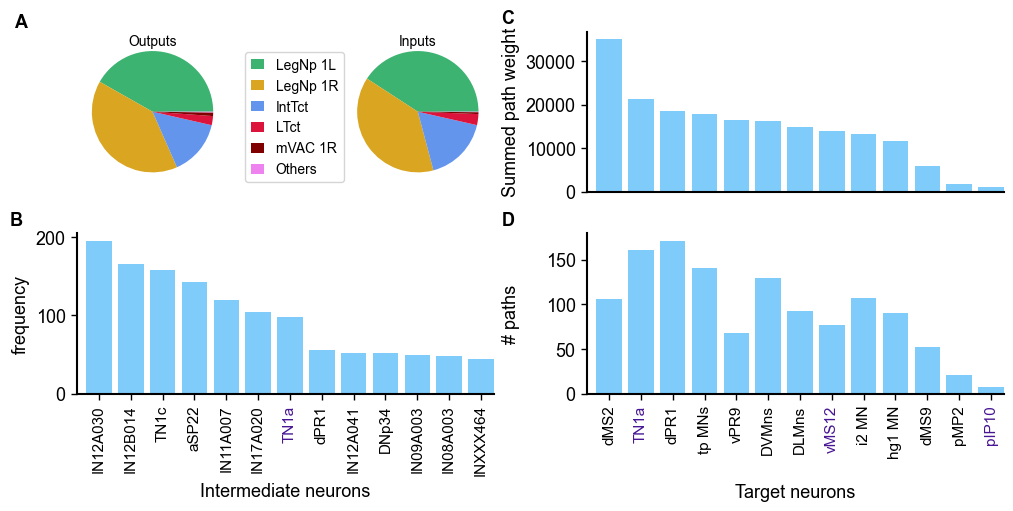

In [11]:
# Set a cutoff for the number of occurrences of the intermediate neurons
disp_cutoff = 40

# Set up a new figure
fig, ax = plt.subplot_mosaic([["A1", "A2", "C", "C"],
                              ["B", "B", "D", "D"]], figsize=(10, 5), constrained_layout=False)
# Get the axes handles 
axa1 = ax["A1"]
axa2 = ax["A2"]
axb = ax["B"]
axc = ax["C"]
axd = ax["D"]


# Define a color list
colors_list = ["mediumseagreen", "goldenrod", "cornflowerblue", "crimson", "maroon", "violet", "deepskyblue", "gold", "darkorange"]

# Plot the pre- and postsynaptic sites as pie plots
wedges_a1, text_a1 = axa1.pie(presyn_count_srt, colors=colors_list)
wedges_a2, text_a2 = axa2.pie(postsyn_count_srt, colors=colors_list)
# Add text to describe the pies
axa1.text(0, 1.1, "Outputs", horizontalalignment="center")
axa2.text(0, 1.1, "Inputs", horizontalalignment="center")

# Plot the frequencies of the intermediate neurons as a bar plot
axb.bar(intermed_unique_srt[freqs_intermed_srt>disp_cutoff], 
          freqs_intermed_srt[freqs_intermed_srt>disp_cutoff], color="#7FCBFA")

# Plot the summed path weights as a bar plot
axc.bar(trgt_unique_srt, pweights_sum_srt, color="#7FCBFA")
# Plot the number of paths for each target as a bar plot
axd.bar(trgt_unique_srt, freqs_trgt_srt, color="#7FCBFA")


# Add a legend
axa2.legend(wedges_a2, roi_labels_post, ncols=1, fontsize=10, bbox_to_anchor=(0.02, 0.9), bbox_transform=axa2.transAxes)

# Rotate the x labels and adjust size
axb.tick_params(axis='x', labelrotation = 90, labelsize=11)
axc.tick_params(axis='x', labelrotation = 90, size=0)
axd.tick_params(axis='x', labelrotation = 90, labelsize=11)

# Adjust x limits on the bar plot axes
axb.set_xlim(left=-0.7)
axc.set_xlim(left=-0.7)
axd.set_xlim(left=-0.7)

# Color-code the bar plot axes for neurons tested in this study
myplt.ax_colorcode(axb, col_dict_this_study, axis="x")
myplt.ax_colorcode(axc, col_dict_this_study, axis="x")
myplt.ax_colorcode(axd, col_dict_this_study, axis="x")

# Label the axes
axb.set_ylabel("frequency")
axc.set_ylabel("Summed path weight")
axd.set_ylabel("# paths", labelpad=18.5)

axb.set_xlabel("Intermediate neurons", labelpad=5)
axc.set_xticklabels([])
axd.set_xlabel("Target neurons", labelpad=18)

# Set titles
axa1.set_title("A", x=-0.41)
axb.set_title("B", x=-0.16)
axc.set_title("C", x=-0.205)
axd.set_title("D", x=-0.205)

# Adjust the subplot layout
plt.subplots_adjust(wspace=0.6, hspace=0.3, left=0.07, right=0.99, top=0.94, bottom=0.213)

# Save figure
fig.savefig("../figures_wip/vPR13_connectivity.pdf")

#### Find details on inhibitory intermediate neurons 

In [12]:
# Get the neurotransmitters of all intermediate neurons shown in the plot
nt_intermeds = neuron_info.loc[neuron_info["type"].isin(intermed_unique_srt[freqs_intermed_srt>disp_cutoff]), ["type", "predictedNt", "predictedNtProb"]]

# Create a dict mapping neuron type to neurotransmitter and its probability
nt_dict_intermeds = {}
for neuron in nt_intermeds["type"].unique():
    # Get info
    nt = np.unique(np.array(nt_intermeds.loc[nt_intermeds["type"] == neuron, "predictedNt"]))
    ntProbs = np.array(nt_intermeds.loc[nt_intermeds["type"] == neuron, "predictedNtProb"])
    # Store in dict
    if nt.size == 1:
        nt_dict_intermeds[neuron] = f"{nt[0]} with average prob.: {np.mean(ntProbs)}"
    else:
        nt_dict_intermeds[neuron] = f"{nt} with average prob.: {ntProbs}"

# Print the results for inspection
for key,val in nt_dict_intermeds.items():
    print(f"{key}'s \t neurotransmitter is \t {val}")

# Get all paths starting at vPR13 ending in the song circuit or motor neurons
vPR13_paths = nx.all_simple_paths(ngraph_ntype, "vPR13", neuron_list[neuron_list != "vPR13"], cutoff=3)
# Get all paths with the two GABA-ergic neurons 
pathes_plus_gaba = [ p for p in vPR13_paths if len(p) == 3 and p[1] in ["IN09A003", "IN12B014"] ]

# Get paths again
vPR13_paths = nx.all_simple_paths(ngraph_ntype, "vPR13", neuron_list[neuron_list != "vPR13"], cutoff=3)
# Get the corresponding path weights for GABA-ergic neurons
pathes_plus_glu = [ p for p in vPR13_paths if len(p) == 3 and p[1] == "IN08A003" ]

# Repeat for the gultamatergic neuron
vPR13_paths = nx.all_simple_paths(ngraph_ntype, "vPR13", neuron_list[neuron_list != "vPR13"], cutoff=3)
pathweights_plus_glu = [ nx.path_weight(ngraph_ntype, p, weight="weight") for p in vPR13_paths if len(p) == 3 and p[1] == "IN08A003" ]

vPR13_paths = nx.all_simple_paths(ngraph_ntype, "vPR13", neuron_list[neuron_list != "vPR13"], cutoff=3)
pathweights_plus_gaba = [ nx.path_weight(ngraph_ntype, p, weight="weight") for p in vPR13_paths if len(p) == 3 and p[1] in ["IN09A003", "IN12B014"] ]

# Print the results
print("\nFollowing GABA-ergic pathways exist with only 1 intermediate neuron:\n ", pathes_plus_gaba, 
      "\n  Corresponding path weights are:", pathweights_plus_gaba)

print("\nFollowing glutamatergic pathways exist with only 1 intermediate neuron:\n ", pathes_plus_glu, 
      "\n  Corresponding path weights are:", pathweights_plus_glu)

dPR1's 	 neurotransmitter is 	 acetylcholine with average prob.: 0.84183545
INXXX464's 	 neurotransmitter is 	 acetylcholine with average prob.: 0.83691851
IN08A003's 	 neurotransmitter is 	 glutamate with average prob.: 0.9515508
IN09A003's 	 neurotransmitter is 	 gaba with average prob.: 0.823403355
aSP22's 	 neurotransmitter is 	 acetylcholine with average prob.: 0.96387005
IN17A020's 	 neurotransmitter is 	 acetylcholine with average prob.: 0.9410574916666666
IN12B014's 	 neurotransmitter is 	 gaba with average prob.: 0.8460932824999999
DNp34's 	 neurotransmitter is 	 acetylcholine with average prob.: 0.97792178
TN1a's 	 neurotransmitter is 	 acetylcholine with average prob.: 0.8500239368181817
IN12A030's 	 neurotransmitter is 	 acetylcholine with average prob.: 0.870335025
IN11A007's 	 neurotransmitter is 	 acetylcholine with average prob.: 0.9319663028571429
TN1c's 	 neurotransmitter is 	 acetylcholine with average prob.: 0.9447016376923079
IN12A041's 	 neurotransmitter is 	 acet

### Create overviews of the input and output regions for each neuron type

In [47]:
all_post_roi_labels = []
all_pre_roi_labels = []
all_presyn_cnts = []
all_postsyn_cnts = []

for ntype in ["TN1a", "vMS12", "pIP10", "dPR1"]:
    # Get the ROI infos
    roi_infos = neuron_info.loc[neuron_info["type"] == ntype, "roiInfo"].to_numpy()

    # Sum the counts of pre- and postsynaptic site on the vPR13 neurons
    roi_labels, presyn_count, postsyn_count = cfun.roi_info_summary(roi_infos)

    roi_label_dict = {"CV":"CV", "IntTct":"IntTct", "LTct":"LTct", "LegNp(T1)(L)":"LegNp 1L", "LegNp(T1)(R)":"LegNp 1R", "LegNp(T2)(L)":"LegNp 2L", "LegNp(T2)(R)":"LegNp 2R",
                    "WTct(UTct-T2)(L)":"WTct L", "WTct(UTct-T2)(R)":"WTct R", "mVAC(T1)(R)":"mVAC 1R", "mVAC(T1)(L)":"mVAC 1L", "HTct(UTct-T3)(L)":"HTct 3L", 
                    "HTct(UTct-T3)(R)":"HTct 3R", "LegNp(T3)(R)":"LegNp 3R", "LegNp(T3)(L)":"LegNp 3L"}
    
    # Exchange roi labels to shorter versions
    roi_labels = np.array([ roi_label_dict[roil] if roil in roi_label_dict else roil for roil in roi_labels ])

    # Get sort indices for the counts
    srt_idx_pre = np.argsort(presyn_count)[::-1]
    srt_idx_post = np.argsort(postsyn_count)[::-1]
    # Apply sort indices
    presyn_count_srt = presyn_count[srt_idx_pre]
    roi_labels_pre = roi_labels[srt_idx_pre]
    postsyn_count_srt = postsyn_count[srt_idx_post]
    roi_labels_post = roi_labels[srt_idx_post]

    # Filter out ROIs with less than 30 synaptic sites, sum them
    presyn_lt30 = np.sum(presyn_count_srt[presyn_count_srt < 100])
    postsyn_lt30 = np.sum(postsyn_count_srt[postsyn_count_srt < 100])

    # Add the summed counts and a label
    roi_labels_post = np.append(roi_labels_post[postsyn_count_srt >= 100], "Others")
    roi_labels_pre = np.append(roi_labels_pre[presyn_count_srt >= 100], "Others")
    presyn_count_srt = np.append(presyn_count_srt[presyn_count_srt >= 100], presyn_lt30)
    postsyn_count_srt = np.append(postsyn_count_srt[postsyn_count_srt >= 100], postsyn_lt30)


    # Store results
    all_post_roi_labels.append(roi_labels_post)
    all_pre_roi_labels.append(roi_labels_pre)
    all_presyn_cnts.append(presyn_count_srt)
    all_postsyn_cnts.append(postsyn_count_srt)

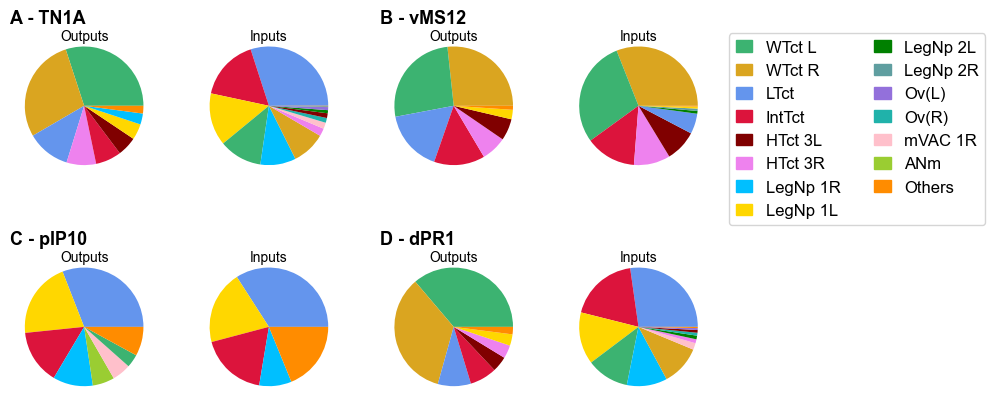

In [118]:
# Define a color dict
colors_dict = {"WTct L":"mediumseagreen", "WTct R":"goldenrod", "LTct":"cornflowerblue", "IntTct":"crimson", "HTct 3L":"maroon", "HTct 3R":"violet", 
               "LegNp 1R":"deepskyblue", "LegNp 1L":"gold", "LegNp 2L":"green", "LegNp 2R":"cadetblue", "Ov(L)":"mediumpurple", "Ov(R)":"lightseagreen",
               "mVAC 1R":"pink", "ANm":"yellowgreen", "Others":"darkorange"}

# Set up figure
fig4, ax4 = plt.subplots(2, 4, figsize=(10,4), constrained_layout=False)
ax4 = ax4.flatten()

# Plot the pre- and postsynaptic sites as pie plots
wedges_a1, text_a = ax4[0].pie(all_presyn_cnts[0], colors=[ colors_dict[label] for label in all_pre_roi_labels[0] ])
wedges_b1, text_b = ax4[2].pie(all_presyn_cnts[1], colors=[ colors_dict[label] for label in all_pre_roi_labels[1] ])
wedges_c1, text_c = ax4[4].pie(all_presyn_cnts[2], colors=[ colors_dict[label] for label in all_pre_roi_labels[2] ])
wedges_d1, text_d = ax4[6].pie(all_presyn_cnts[3], colors=[ colors_dict[label] for label in all_pre_roi_labels[3] ])

wedges_a2, text_a = ax4[1].pie(all_postsyn_cnts[0], colors=[ colors_dict[label] for label in all_post_roi_labels[0] ])
wedges_b2, text_b = ax4[3].pie(all_postsyn_cnts[1], colors=[ colors_dict[label] for label in all_post_roi_labels[1] ])
wedges_c2, text_c = ax4[5].pie(all_postsyn_cnts[2], colors=[ colors_dict[label] for label in all_post_roi_labels[2] ])
wedges_d2, text_d = ax4[7].pie(all_postsyn_cnts[3], colors=[ colors_dict[label] for label in all_post_roi_labels[3] ])

# Add text to describe the pies
ax4[0].text(0, 1.1, "Outputs", horizontalalignment="center")
ax4[2].text(0, 1.1, "Outputs", horizontalalignment="center")
ax4[4].text(0, 1.1, "Outputs", horizontalalignment="center")
ax4[6].text(0, 1.1, "Outputs", horizontalalignment="center")

ax4[1].text(0, 1.1, "Inputs", horizontalalignment="center")
ax4[3].text(0, 1.1, "Inputs", horizontalalignment="center")
ax4[5].text(0, 1.1, "Inputs", horizontalalignment="center")
ax4[7].text(0, 1.1, "Inputs", horizontalalignment="center")

# Add titles
ax4[0].set_title("A - TN1A")
ax4[2].set_title("B - vMS12")
ax4[4].set_title("C - pIP10")
ax4[6].set_title("D - dPR1")

proxy_patches = [ patches.Patch(color=colors_dict[key], label=key) for key in colors_dict.keys() ]
ax4[3].legend(handles=proxy_patches, ncol=2, bbox_to_anchor=(1.1, 1), bbox_transform=ax4[3].transAxes)

# Adjust the subplot layout
plt.subplots_adjust(wspace=0.3, hspace=0.2, left=0.01, right=0.72, top=0.98, bottom=0.01)

# Save figure
fig4.savefig("../figures_wip/inputs_outputs_others.pdf")